In [1]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [2]:
import warnings
warnings.simplefilter('ignore')

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.feature_selection import get_constant_features
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer

%matplotlib inline

In [4]:
!nvidia-smi

Sat Feb 10 00:05:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             22W /   93W |     244MiB /   6144MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [6]:
df.shape

(6362620, 11)

In [7]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Description about the data - 

1. **step:** Represents a unit of time in the real world, where 1 step equals 1 hour. Total steps are 744, equivalent to 30 days of simulation.

2. **type:** Describes the type of transaction, such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

3. **amount:** Indicates the amount of the transaction in the local currency.

4. **nameOrig:** Refers to the customer who initiated the transaction.

5. **oldbalanceOrg:** Represents the initial balance before the transaction for the customer initiating it.

6. **newbalanceOrig:** Reflects the new balance after the transaction for the customer initiating it.

7. **nameDest:** Denotes the customer who is the recipient of the transaction.

8. **oldbalanceDest:** Indicates the initial balance before the transaction for the recipient customer. Note that there is no information for customers whose names start with "M" (Merchants).

9. **newbalanceDest:** Represents the new balance after the transaction for the recipient customer. Note that there is no information for customers whose names start with "M" (Merchants).

10. **isFraud:** Indicates whether the transaction is made by fraudulent agents within the simulation. The fraudulent behavior aims to profit by taking control of customers' accounts and emptying funds through transfers and cashing out.

11. **isFlaggedFraud:** Flags illegal attempts in the business model to control massive transfers between accounts. An illegal attempt in this dataset is defined as a transfer of more than 200,000 in a single transaction.

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [10]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### isFlaggedFraud = 0 means it isn't a fraud.
#### isFlaggedFraud = 1 means it is a fraud.

In [13]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [14]:
## checking if the flaggedfraud are actually fraud

temp_fraud = df.loc[df['isFlaggedFraud'] == 1, ['isFlaggedFraud', 'isFraud']]
temp_fraud

,isFlaggedFraud,isFraud
2736446,1,1
3247297,1,1
3760288,1,1
5563713,1,1
5996407,1,1
5996409,1,1
6168499,1,1
6205439,1,1
6266413,1,1
6281482,1,1


In [15]:
## checking if there are transactions with amount > 200,000 and still not flagged as fraud

temp_fraud_2 = df.loc[(df['amount'] > 200000) & (df['isFlaggedFraud'] == 0), ['amount', 'isFlaggedFraud']]
print(len(temp_fraud_2))

1673554


## <u>*Observations*</u> - 

1. __*Amount*__,  __*oldbalanceOrg*__, __*newbalanceOrig*__ have a higher spread of data - mean and standard deviation are far apart. 
<br>

2. There are no null values in the dataset. 
<br>

3. With respect to isFlaggedFraud column - <br>
    - "flagged" is for isFlaggedFraud column and "marked" is for "isFraud" column.
    - Whenever a transaction was above 200,000 and was 'flagged' as Fraud, it was also 'marked' as Fraud.
    - But, there are transactions above 200,000 which are not flagged as fraud. 
    - Therefore, in such scenarios the credibility of variable "isFlaggedFraud" is in jeopardy.
    - We can treat this feature as insignificant and discard it in the dataset without loosing information.
    - We can drop the "isFlaggedFraud" column from the dataset as our concern is the end part - if the transaction was fraudulent or not. "isFlaggedFraud" column can be used when making an application which can incorporate this requirement. 
<br>

4. "Type" column should be converted to numerical. 
<br>

5. Columns - nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest - are very important because these reveal what type of accounts are targetted when a fraud txn happens. 

In [16]:
print("Shape before drop = {}".format(df.shape))
df.drop(columns=['isFlaggedFraud'], axis = 1, inplace=True)
print("After before drop = {}".format(df.shape))

Shape before drop = (6362620, 11)
After before drop = (6362620, 10)


In [17]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [97]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

print("X shape = {}\ny shape = {}".format(X.shape, y.shape))

X shape = (6362620, 9)
y shape = (6362620,)


## Data Analysis, Preprocessing, Feature Engineering

In [98]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


### --> Duplicate Rows

In [99]:
X.duplicated().sum()

0

### --> Constant, Quasi-Constant Features

In [100]:
get_constant_features(X)

,Desc,Var,Value,Perc


In [101]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

In [102]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = X[numerical_columns]
numerical_columns

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,9839.64,170136.00,160296.36,0.00,0.00
1,1,1864.28,21249.00,19384.72,0.00,0.00
2,1,181.00,181.00,0.00,0.00,0.00
3,1,181.00,181.00,0.00,21182.00,0.00
4,1,11668.14,41554.00,29885.86,0.00,0.00
...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11
6362618,743,850002.52,850002.52,0.00,0.00,0.00


### --> Outlier Analysis

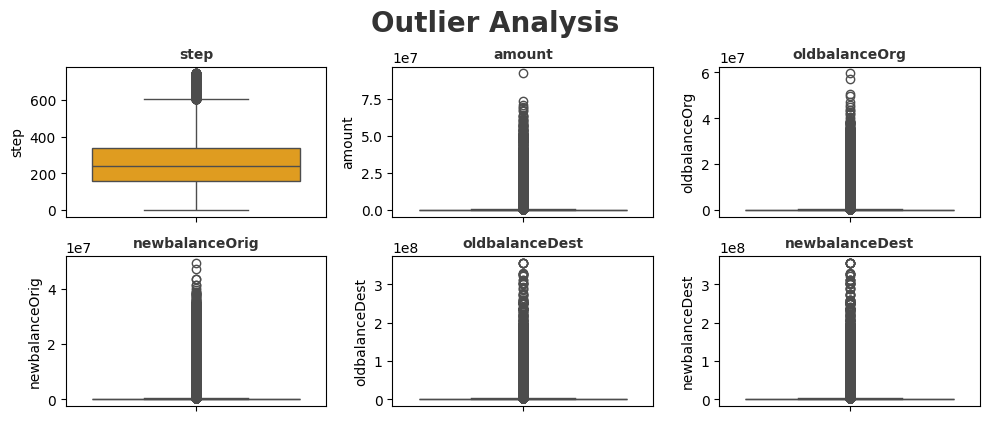

In [103]:
plt.figure(figsize=(10, 10))
plt.suptitle('Outlier Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(numerical_columns.columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(numerical_columns[column], color='orange')
    plt.title(column, fontsize=10, fontweight='bold', alpha=0.8)
    plt.tight_layout()

plt.show()

In [104]:
numerical_columns.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


### <u>*__Observations__*</u> - 

1. "Amount" - max value is very much higher than than 75% value. 
2. For other columns, the presence of outliers, from the graph, is very minimal and is close enough to the data. But will be checked with quantiles. 



### <u>Extra Observations from code below</u> - <br>

1. The column 'oldbalanceOrg' has values which is equal to 0 and the data points associated with this are marked as Fraud.<br>

2. Why this observation? 
    - This observation was prudent because it raises questions that if an account, with zero balance, is used for transactions with different forms of payment like cash_out, transfer, etc., then is it a problem with the data or is it fraud. <br>

3. The results I inferred were as follows - 
    - <u>Data Entry Errors</u>: It's possible that there are errors in the data recording process, leading to transactions being attributed to accounts with zero initial balance inaccurately. In this case, fault from the multi-agent based simulations (MABS).<br>

    - <u>Fraudulent Activity</u>: Transactions from accounts with zero initial balance might indicate fraudulent behavior, especially if these transactions involve significant amounts of money or unusual patterns.<br>
    
    - <u>System Glitches</u>: In some cases, system glitches or errors could lead to transactions being recorded incorrectly or attributed to the wrong accounts. Again in this case, the MABS.<br>
    
    - <u>Money Laundering</u>: Accounts with zero initial balance might be used in attempts to launder money or obscure the source of funds. Such transactions might involve moving money through multiple accounts rapidly.

##### ==================================================

In [105]:
X.loc[(X['oldbalanceOrg'] == 0) & (y == 1), ['amount','oldbalanceOrg', 'newbalanceOrig', 'type', 'oldbalanceDest', 'newbalanceDest']]

,amount,oldbalanceOrg,newbalanceOrig,type,oldbalanceDest,newbalanceDest
724,416001.33,0.0,0.0,CASH_OUT,102.00,9291619.62
14861,181728.11,0.0,0.0,CASH_OUT,11397.00,184477.77
25875,1078013.76,0.0,0.0,TRANSFER,0.00,970749.68
77745,277970.88,0.0,0.0,CASH_OUT,0.00,277970.88
138559,1933920.80,0.0,0.0,TRANSFER,1283762.85,3217683.65
169998,149668.66,0.0,0.0,CASH_OUT,44170.11,193838.76
178668,222048.71,0.0,0.0,CASH_OUT,2979.00,225027.71
200845,454859.39,0.0,0.0,CASH_OUT,0.00,454859.39
291459,95428.32,0.0,0.0,CASH_OUT,0.00,95428.32
296686,39713.28,0.0,0.0,CASH_OUT,1274866.51,1314579.79


In [106]:
X.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [107]:
X[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,C1231006815,M1979787155
1,C1666544295,M2044282225
2,C1305486145,C553264065
3,C840083671,C38997010
4,C2048537720,M1230701703
...,...,...
6362615,C786484425,C776919290
6362616,C1529008245,C1881841831
6362617,C1162922333,C1365125890
6362618,C1685995037,C2080388513


In [108]:
X.loc[X['nameOrig'] == X['nameDest'], ['nameOrig', 'nameDest']]

,nameOrig,nameDest


##### ==================================================

#### Continuing outlier analysis - 

In [109]:
def quantile_info(X, columns):
    dataframe = pd.DataFrame(index=columns.columns) 
    mean = []
    std_dev = []
    min_val = []
    percentile_75 = []
    percentile_90 = []
    percentile_95 = []
    percentile_99 = []
    max_val = []
    max_minus_99 = []
    for column in columns.columns: 
        mean.append(X[column].mean())
        std_dev.append(X[column].std())
        min_val.append(X[column].min())
        percentile_75.append(X[column].quantile(0.75))
        percentile_90.append(X[column].quantile(0.90))
        percentile_95.append(X[column].quantile(0.95))
        percentile_99.append(X[column].quantile(0.99))
        max_minus_99.append(X[column].max() - X[column].quantile(0.99))
        max_val.append(X[column].max())

    dataframe['Mean'] = mean
    dataframe['Standard Deviation'] = std_dev
    dataframe['Minimum Value'] = min_val
    dataframe['75th Percentile'] = percentile_75
    dataframe['90th Percentile'] = percentile_90
    dataframe['95th Percentile'] = percentile_95
    dataframe['99th Percentile'] = percentile_99
    dataframe['Maximum Value'] = max_val
    dataframe['Max - 99th'] = max_minus_99

    return dataframe

numerical_data = X.select_dtypes(include=['int64', 'float64'])
quantile_info(X, numerical_data)

,Mean,Standard Deviation,Minimum Value,75th Percentile,90th Percentile,95th Percentile,99th Percentile,Maximum Value,Max - 99th
step,2.433972e+02,1.423320e+02,1.0,3.350000e+02,399.000,4.900000e+02,6.810000e+02,7.430000e+02,6.200000e+01
amount,1.798619e+05,6.038582e+05,0.0,2.087215e+05,365423.309,5.186342e+05,1.615979e+06,9.244552e+07,9.082954e+07
oldbalanceOrg,8.338831e+05,2.888243e+06,0.0,1.073152e+05,1822508.289,5.823702e+06,1.602726e+07,5.958504e+07,4.355778e+07
newbalanceOrig,8.551137e+05,2.924049e+06,0.0,1.442584e+05,1970344.793,5.980262e+06,1.617616e+07,4.958504e+07,3.340888e+07
oldbalanceDest,1.100702e+06,3.399180e+06,0.0,9.430367e+05,2914266.669,5.147230e+06,1.237182e+07,3.560159e+08,3.436441e+08
newbalanceDest,1.224996e+06,3.674129e+06,0.0,1.111909e+06,3194869.671,5.515716e+06,1.313787e+07,3.561793e+08,3.430414e+08


In [110]:
df.loc[df['amount'] == df['amount'].max(), ['isFraud']]

,isFraud
3686583,0


In [111]:
df.loc[df['oldbalanceOrg'] == df['oldbalanceOrg'].max(), ['isFraud']]

,isFraud
5996399,1


In [112]:
df.loc[df['newbalanceOrig'] == df['newbalanceOrig'].max(), ['isFraud']]

,isFraud
5996399,1


In [113]:
df.loc[df['oldbalanceDest'] == df['oldbalanceDest'].max(), ['isFraud']]

,isFraud
5920180,0


In [114]:
df.loc[df['newbalanceDest'] == df['newbalanceDest'].max(), ['isFraud']]

,isFraud
5920180,0


### <u>__*Inference*__</u> - 

1. The presence of outliers are there in every column except step. <br>

2. The difference between the maximum and 99th percentile value are huge across the columns. <br>

3. The problem - <br>
    - Although the extreme most values look like outlier, they are playing a crucial role in the identification of Fraud transactions in case of oldbalanceOrg and newbalanceOrig.<br>
    - We would lose a very important part of the data source if we treat these outliers. <br>

4. So, we would not treat outliers. 

### --> Analysis of Types of Transactions

In [115]:
txn_types = X['type'].value_counts()
txn_types

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

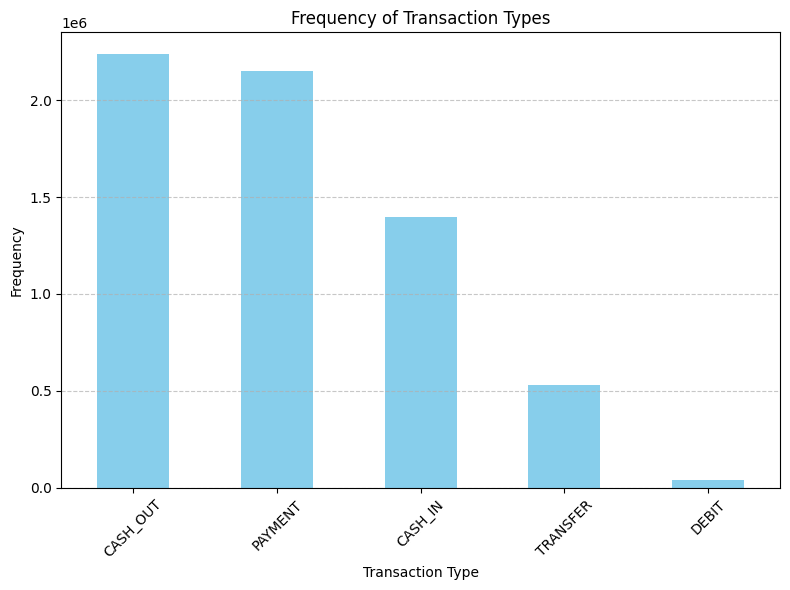

In [116]:
txn_counts = X['type'].value_counts()

plt.figure(figsize=(8, 6))
txn_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

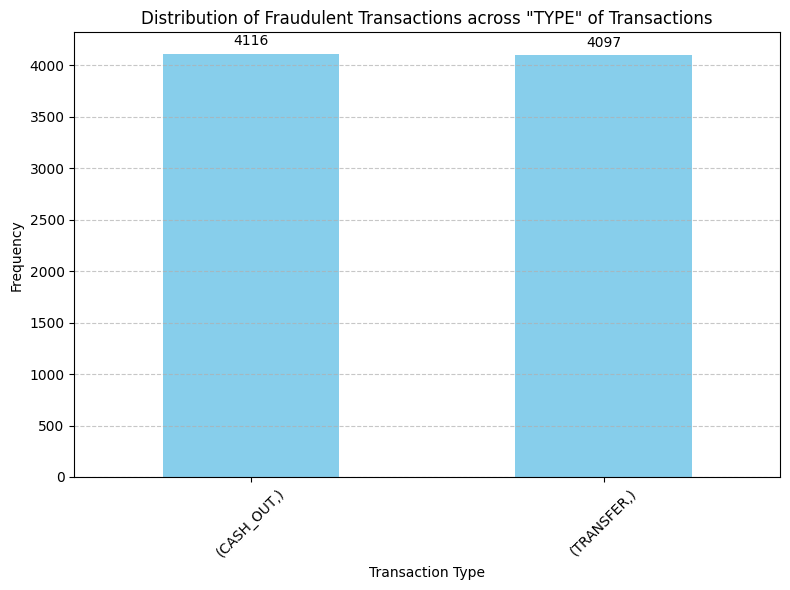

In [117]:
fraud_txn_counts = X.loc[y == 1, ['type']].value_counts()

plt.figure(figsize=(8, 6))
ax = fraud_txn_counts.plot(kind='bar', color='skyblue')
fraud_txn_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Fraudulent Transactions across "TYPE" of Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(fraud_txn_counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Observations - 

1. Fraud transactions have been only done via cash_out and transfer type. <br>

2. More fraud cases are happening via "non-digital" mode or cash_out to not leave any traces behind. 

### --> Correlation between the data

In [118]:
numerical_columns

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,9839.64,170136.00,160296.36,0.00,0.00
1,1,1864.28,21249.00,19384.72,0.00,0.00
2,1,181.00,181.00,0.00,0.00,0.00
3,1,181.00,181.00,0.00,21182.00,0.00
4,1,11668.14,41554.00,29885.86,0.00,0.00
...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11
6362618,743,850002.52,850002.52,0.00,0.00,0.00


<Axes: >

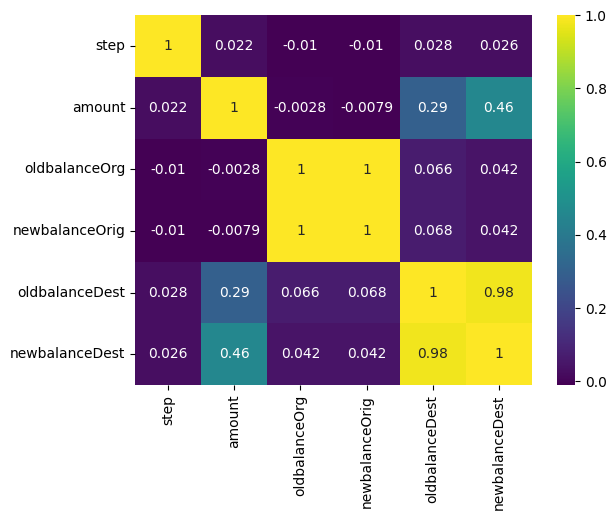

In [119]:
sns.heatmap(numerical_columns.corr(), annot=True, cmap='viridis')

In [120]:
numerical_columns.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000


### <u>__*Inference*__</u> 

1. Very high correlation between "oldbalanceOrg" and "newbalanceOrig". <br>

2. Very high correlation between "oldbalanceDest" and "newbalanceDest". <br>

3. The regular technique - to remove one of the feature which is highly correlated with other - will not be done for the following reasons :<br>
    - <u>Domain Relevance</u>: The features in the dataset might have inherent correlations due to the nature of financial transactions. For example, the balances of the originating and destination accounts might naturally be correlated in certain types of transactions. <br>

    - <u>Information Loss</u>: Removing highly correlated columns could result in the loss of valuable information. Additionally, these features are crucial for detecting fraudulent activities and by reducing even 1 column, we could potentially lose a lot of data. <br>
    
    - <u>Model Interpretability</u>: In fraud detection, it's often essential to have transparency and interpretability in your models. Removing features might make it harder to interpret the model's decisions and understand the factors contributing to fraud detection.

In [121]:
X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00


### Encoding Variables

In [122]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


In [123]:
X['nameOrig'].nunique(), X['nameDest'].nunique()

(6353307, 2722362)

### Steps -

1. "type" could be one-hot encoded.
2. Due to the unique nature of nameOrig and nameDest, we cannot use any random encoding technique on it. We can extract the C (customer) and M (merchants) from both these columns to understand the pattern between customer-merchant, customer-customer transactions and the relation of this with Frauds. 

In [124]:
dummy_variables = pd.get_dummies(X['type'])
dummy_variables = dummy_variables.apply(lambda x: x.apply(lambda y: 1 if y > 0 else 0))

X = pd.concat([X, dummy_variables], axis=1)
X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1,0,0,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,0,0,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1,0,0,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,0,0,0,1


In [125]:
X['nameDest'].nunique(), X['nameOrig'].nunique()

(2722362, 6353307)

In [126]:
X[['nameDest', 'nameOrig']]

,nameDest,nameOrig
0,M1979787155,C1231006815
1,M2044282225,C1666544295
2,C553264065,C1305486145
3,C38997010,C840083671
4,M1230701703,C2048537720
...,...,...
6362615,C776919290,C786484425
6362616,C1881841831,C1529008245
6362617,C1365125890,C1162922333
6362618,C2080388513,C1685995037


In [127]:
X['nameDest_C'] = X['nameDest'].str.startswith('C').astype(int)
X['nameDest_M'] = X['nameDest'].str.startswith('C').astype(int)

X['nameOrig_C'] = X['nameOrig'].str.startswith('C').astype(int)

In [128]:
X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,nameDest_C,nameDest_M,nameOrig_C
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,1,0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1,0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,0,0,1,1,1,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,0,0,1,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1,0,0,0,1,1,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,0,0,0,1,1,1,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1,0,0,0,1,1,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,0,0,0,1,1,1,1


In [132]:
X.drop(columns=['type', 'nameDest', 'nameOrig'], axis=1, inplace=True)

In [134]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,nameDest_C,nameDest_M,nameOrig_C
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,0,0,1
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,0,0,1
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,1,1,1
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0,1,1,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0,0,0,1


## Imbalanced Dataset

In [135]:
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

#### Observation - 

1. Dataset is highly imbalanced with fraud transactions being only 8213 out of approx. 6.3 million data points. 
2. Will have to augment the dataset to make it balance and to build a model without any bias. 

In [136]:
sm = SMOTETomek(random_state=42)

In [137]:
X_resampled, y_resampled = sm.fit_resample(X, y)

In [138]:
print('OG : ' + str(Counter(y)))
print('After Under Sampling : ' + str(Counter(y_resampled)))

OG : Counter({0: 6354407, 1: 8213})
After Under Sampling : Counter({0: 6353835, 1: 6353835})


In [139]:
X_resampled.shape, y_resampled.shape

((12707670, 14), (12707670,))

In [140]:
X_resampled

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,nameDest_C,nameDest_M,nameOrig_C
0,1,9.839640e+03,1.701360e+05,160296.36,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
1,1,1.864280e+03,2.124900e+04,19384.72,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
2,1,1.810000e+02,1.810000e+02,0.00,0.000000,0.000000e+00,0,0,0,0,1,1,1,1
3,1,1.810000e+02,1.810000e+02,0.00,21182.000000,0.000000e+00,0,1,0,0,0,1,1,1
4,1,1.166814e+04,4.155400e+04,29885.86,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12707665,248,1.622713e+06,1.622713e+06,0.00,505566.365403,2.138033e+06,0,1,0,0,0,1,1,1
12707666,617,1.000000e+07,1.000000e+07,0.00,0.000000,1.000000e+07,0,1,0,0,0,1,1,1
12707667,208,9.018546e+05,9.018546e+05,0.00,714785.333096,1.616640e+06,0,1,0,0,0,1,1,1
12707668,404,1.365631e+05,1.365631e+05,0.00,0.000000,0.000000e+00,0,0,0,0,1,1,1,1


In [142]:
y_resampled

0           0
1           0
2           1
3           1
4           0
           ..
12707665    1
12707666    1
12707667    1
12707668    1
12707669    1
Name: isFraud, Length: 12707670, dtype: int64

In [146]:
X_resampled.to_csv('X_resampled.csv', index = False)
y_resampled.to_csv('y_resampled.csv', index = False)

In [147]:
X_sampled = pd.read_csv('X_resampled.csv')
X_sampled

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,nameDest_C,nameDest_M,nameOrig_C
0,1,9.839640e+03,1.701360e+05,160296.36,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
1,1,1.864280e+03,2.124900e+04,19384.72,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
2,1,1.810000e+02,1.810000e+02,0.00,0.000000,0.000000e+00,0,0,0,0,1,1,1,1
3,1,1.810000e+02,1.810000e+02,0.00,21182.000000,0.000000e+00,0,1,0,0,0,1,1,1
4,1,1.166814e+04,4.155400e+04,29885.86,0.000000,0.000000e+00,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12707665,248,1.622713e+06,1.622713e+06,0.00,505566.365403,2.138033e+06,0,1,0,0,0,1,1,1
12707666,617,1.000000e+07,1.000000e+07,0.00,0.000000,1.000000e+07,0,1,0,0,0,1,1,1
12707667,208,9.018546e+05,9.018546e+05,0.00,714785.333096,1.616640e+06,0,1,0,0,0,1,1,1
12707668,404,1.365631e+05,1.365631e+05,0.00,0.000000,0.000000e+00,0,0,0,0,1,1,1,1


In [148]:
y_sampled = pd.read_csv('y_resampled.csv')
y_sampled

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
12707665,1
12707666,1
12707667,1
12707668,1
